In [62]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [63]:
data = pd.read_csv('autoscaling_dataset.csv')

In [64]:
print(data.columns)

Index(['http_req_duration (ms)', 'response_time (ms)', 'vus (users)',
       'success_rate (%)', 'http_reqs (req/sec)', 'cpu_usage (%)',
       'memory_usage (%)', 'latency (ms)', 'throughput (req/sec)'],
      dtype='object')


In [65]:
def calculate_cpu_cores(row):
    if row['cpu_usage (%)'] < 30 and row['response_time (ms)'] < 400:
        return 1
    elif row['cpu_usage (%)'] < 50 and row['response_time (ms)'] < 500:
        return 2
    elif row['cpu_usage (%)'] < 80 or row['response_time (ms)'] < 700:
        return 3
    else:
        return 4

In [66]:
# Create target_containers: based on throughput (req/sec)
def calculate_containers(row):
    if row['throughput (req/sec)'] < 300:
        return 2
    elif row['throughput (req/sec)'] < 700:
        return 3
    else:
        return 4

In [67]:
# Apply the functions
data['target_cpu_cores'] = data.apply(calculate_cpu_cores, axis=1)
data['target_containers'] = data.apply(calculate_containers, axis=1)


In [68]:
# 3. Define Features and Target
features = ['http_req_duration (ms)', 'response_time (ms)', 'vus (users)', 'success_rate (%)',
            'http_reqs (req/sec)', 'cpu_usage (%)', 'memory_usage (%)', 'latency (ms)', 'throughput (req/sec)']

In [69]:
# See first few rows
print(data.head())

# See data types
print(data.dtypes)

# See dataset shape
print("Shape of dataset:", data.shape)

   http_req_duration (ms)  response_time (ms)  vus (users)  success_rate (%)  \
0                2037.614         4084.685564            1               100   
1                2033.795         4048.102856            1               100   
2                2018.210         4041.253090            1               100   
3                2021.587         4046.042919            1               100   
4                2026.228         4053.857088            1               100   

   http_reqs (req/sec)  cpu_usage (%)  memory_usage (%)  latency (ms)  \
0                    1          100.0              80.9   2043.091774   
1                    1          100.0              85.3   2013.059378   
2                    1          100.0              86.6   2021.702766   
3                    1          100.0              90.5   2023.094177   
4                    1          100.0              94.7   2025.782824   

   throughput (req/sec)  target_cpu_cores  target_containers  
0              0.

In [73]:

X = data[features]
y_cpu = data['target_cpu_cores']
y_containers = data['target_containers']

In [74]:
# 4. Train-Test Split
X_train, X_test, y_cpu_train, y_cpu_test = train_test_split(X, y_cpu, test_size=0.2, random_state=42)
_, _, y_containers_train, y_containers_test = train_test_split(X, y_containers, test_size=0.2, random_state=42)


In [75]:
# 5. Train Models
cpu_model = DecisionTreeRegressor(max_depth=100)  # reduced depth for better learning
containers_model = DecisionTreeRegressor(max_depth=100)

In [76]:

cpu_model.fit(X_train, y_cpu_train)
containers_model.fit(X_train, y_containers_train)

DecisionTreeRegressor(max_depth=100)

In [77]:
# 6. Predict
cpu_predictions = cpu_model.predict(X_test)
containers_predictions = containers_model.predict(X_test)

In [78]:
# 7. Evaluation Metrics
cpu_mse = mean_squared_error(y_cpu_test, cpu_predictions)
cpu_r2 = r2_score(y_cpu_test, cpu_predictions)

In [79]:
containers_mse = mean_squared_error(y_containers_test, containers_predictions)
containers_r2 = r2_score(y_containers_test, containers_predictions)

In [80]:
print(f"CPU Model - MSE: {cpu_mse:.2f}, R2 Score: {cpu_r2:.2f}")
print(f"Containers Model - MSE: {containers_mse:.2f}, R2 Score: {containers_r2:.2f}")

CPU Model - MSE: 0.00, R2 Score: 1.00
Containers Model - MSE: 0.00, R2 Score: 1.00


In [81]:
# 8. Save Models
joblib.dump(cpu_model, 'cpu_prediction_model.pkl')
joblib.dump(containers_model, 'containers_prediction_model.pkl')


['containers_prediction_model.pkl']

In [82]:
print("✅ Models Saved Successfully!")

# 9. Plot Results
plt.figure(figsize=(10,5))


✅ Models Saved Successfully!


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

Text(0, 0.5, 'Predicted CPU Cores')

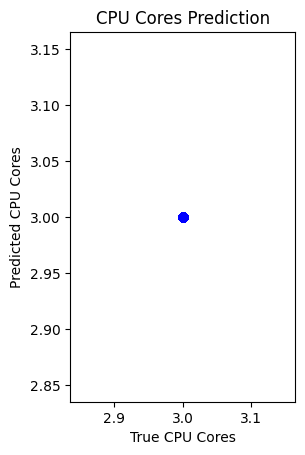

In [83]:
# CPU Plot
plt.subplot(1, 2, 1)
plt.scatter(y_cpu_test, cpu_predictions, color='blue')
plt.plot([y_cpu_test.min(), y_cpu_test.max()], [y_cpu_test.min(), y_cpu_test.max()], 'k--', lw=2)
plt.title('CPU Cores Prediction')
plt.xlabel('True CPU Cores')
plt.ylabel('Predicted CPU Cores')

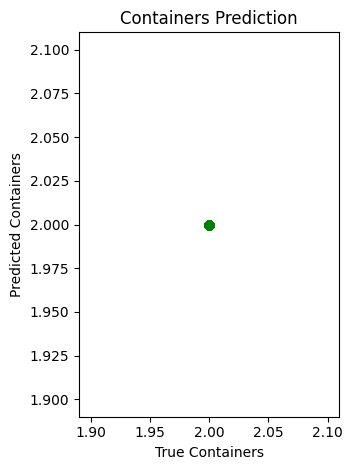

In [84]:
# Containers Plot
plt.subplot(1, 2, 2)
plt.scatter(y_containers_test, containers_predictions, color='green')
plt.plot([y_containers_test.min(), y_containers_test.max()], [y_containers_test.min(), y_containers_test.max()], 'k--', lw=2)
plt.title('Containers Prediction')
plt.xlabel('True Containers')
plt.ylabel('Predicted Containers')

plt.tight_layout()
plt.show()

In [85]:
import pandas as pd
import joblib

# Load Saved Models
cpu_model = joblib.load('cpu_prediction_model.pkl')
containers_model = joblib.load('containers_prediction_model.pkl')


In [86]:
# Low traffic, low CPU usage
test_data_1 = pd.DataFrame([{
    'http_req_duration (ms)': 180,
    'response_time (ms)': 250,
    'vus (users)': 5,
    'success_rate (%)': 98,
    'http_reqs (req/sec)': 200,
    'cpu_usage (%)': 25,
    'memory_usage (%)': 30,
    'latency (ms)': 120,
    'throughput (req/sec)': 220
}])

# Predict
predicted_cpu_1 = cpu_model.predict(test_data_1)
predicted_containers_1 = containers_model.predict(test_data_1)

print(f"Test Case 1 - Predicted CPU Cores: {predicted_cpu_1[0]:.2f}, Predicted Containers: {predicted_containers_1[0]:.2f}")


Test Case 1 - Predicted CPU Cores: 4.00, Predicted Containers: 2.00


In [87]:
# Medium traffic, medium CPU
test_data_2 = pd.DataFrame([{
    'http_req_duration (ms)': 350,
    'response_time (ms)': 450,
    'vus (users)': 20,
    'success_rate (%)': 95,
    'http_reqs (req/sec)': 700,
    'cpu_usage (%)': 55,
    'memory_usage (%)': 60,
    'latency (ms)': 220,
    'throughput (req/sec)': 750
}])

# Predict
predicted_cpu_2 = cpu_model.predict(test_data_2)
predicted_containers_2 = containers_model.predict(test_data_2)

print(f"Test Case 2 - Predicted CPU Cores: {predicted_cpu_2[0]:.2f}, Predicted Containers: {predicted_containers_2[0]:.2f}")


Test Case 2 - Predicted CPU Cores: 4.00, Predicted Containers: 2.00


In [88]:
# High traffic, high CPU
test_data_3 = pd.DataFrame([{
    'http_req_duration (ms)': 600,
    'response_time (ms)': 800,
    'vus (users)': 50,
    'success_rate (%)': 92,
    'http_reqs (req/sec)': 1200,
    'cpu_usage (%)': 85,
    'memory_usage (%)': 85,
    'latency (ms)': 450,
    'throughput (req/sec)': 1300
}])

# Predict
predicted_cpu_3 = cpu_model.predict(test_data_3)
predicted_containers_3 = containers_model.predict(test_data_3)

print(f"Test Case 3 - Predicted CPU Cores: {predicted_cpu_3[0]:.2f}, Predicted Containers: {predicted_containers_3[0]:.2f}")


Test Case 3 - Predicted CPU Cores: 4.00, Predicted Containers: 2.00


In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset from a CSV file
data = pd.read_csv('autoscaling_dataset.csv')  # Replace with your actual file path

# 2. Define Features
features = ['http_req_duration (ms)', 'response_time (ms)', 'vus (users)', 'success_rate (%)',
            'http_reqs (req/sec)', 'cpu_usage (%)', 'memory_usage (%)', 'latency (ms)', 'throughput (req/sec)']

# 3. Create simulated target variables if not already present in the dataset
# Here we simulate the target variables for the sake of demonstration.
# Replace these lines with your actual target columns if available.

data['target_cpu_cores'] = data['cpu_usage (%)'] * 0.1  # Just an example logic
data['target_containers'] = data['vus (users)'] * 2  # Just an example logic

# 4. Define the targets
y_cpu = data['target_cpu_cores']
y_containers = data['target_containers']

X = data[features]

# 5. Split the data into training and testing sets
X_train, X_test, y_train_cpu, y_test_cpu = train_test_split(X, y_cpu, test_size=0.2, random_state=42)
X_train, X_test, y_train_containers, y_test_containers = train_test_split(X, y_containers, test_size=0.2, random_state=42)

# 6. Feature Scaling (optional but may help in some cases)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Train a Decision Tree Regressor for CPU cores prediction
model_cpu = DecisionTreeRegressor(random_state=42)
model_cpu.fit(X_train_scaled, y_train_cpu)

# 8. Train a Decision Tree Regressor for Containers prediction
model_containers = DecisionTreeRegressor(random_state=42)
model_containers.fit(X_train_scaled, y_train_containers)

# 9. Evaluate the models (Mean Squared Error)
y_pred_cpu = model_cpu.predict(X_test_scaled)
mse_cpu = mean_squared_error(y_test_cpu, y_pred_cpu)
print(f"Mean Squared Error for CPU Cores Prediction: {mse_cpu}")

y_pred_containers = model_containers.predict(X_test_scaled)
mse_containers = mean_squared_error(y_test_containers, y_pred_containers)
print(f"Mean Squared Error for Containers Prediction: {mse_containers}")

# 10. Make predictions on new data
new_data = pd.DataFrame({
    'http_req_duration (ms)': [20],
    'response_time (ms)': [10],
    'vus (users)': [10],
    'success_rate (%)': [7],
    'http_reqs (req/sec)': [20],
    'cpu_usage (%)': [10],
    'memory_usage (%)': [30],
    'latency (ms)': [150],
    'throughput (req/sec)': [10]
})

# Scale the new data using the same scaler
new_data_scaled = scaler.transform(new_data[features])

# Predict CPU cores and Containers using the trained models
prediction_cpu = model_cpu.predict(new_data_scaled)
prediction_containers = model_containers.predict(new_data_scaled)

print(f"Predicted CPU Cores for new data: {prediction_cpu[0]}")
print(f"Predicted Containers for new data: {prediction_containers[0]}")


Mean Squared Error for CPU Cores Prediction: 6.191369606003731e-05
Mean Squared Error for Containers Prediction: 0.0
Predicted CPU Cores for new data: 1.0
Predicted Containers for new data: 2.0



📊 CPU Cores Model Metrics:
  - MSE : 0.0007
  - MAE : 0.0094
  - R²  : 0.9987

📊 Containers Model Metrics:
  - MSE : 0.0000
  - MAE : 0.0000
  - R²  : -58977.2458


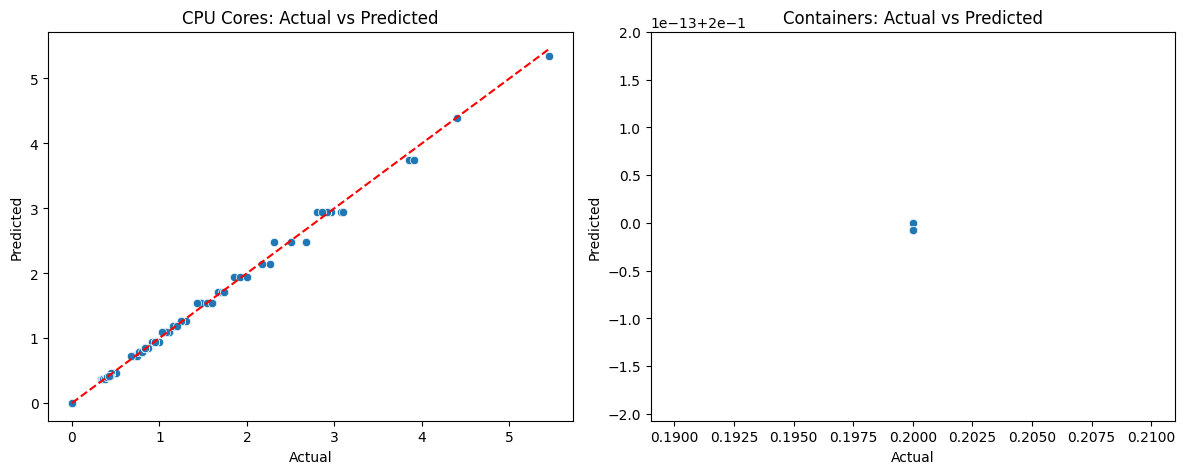

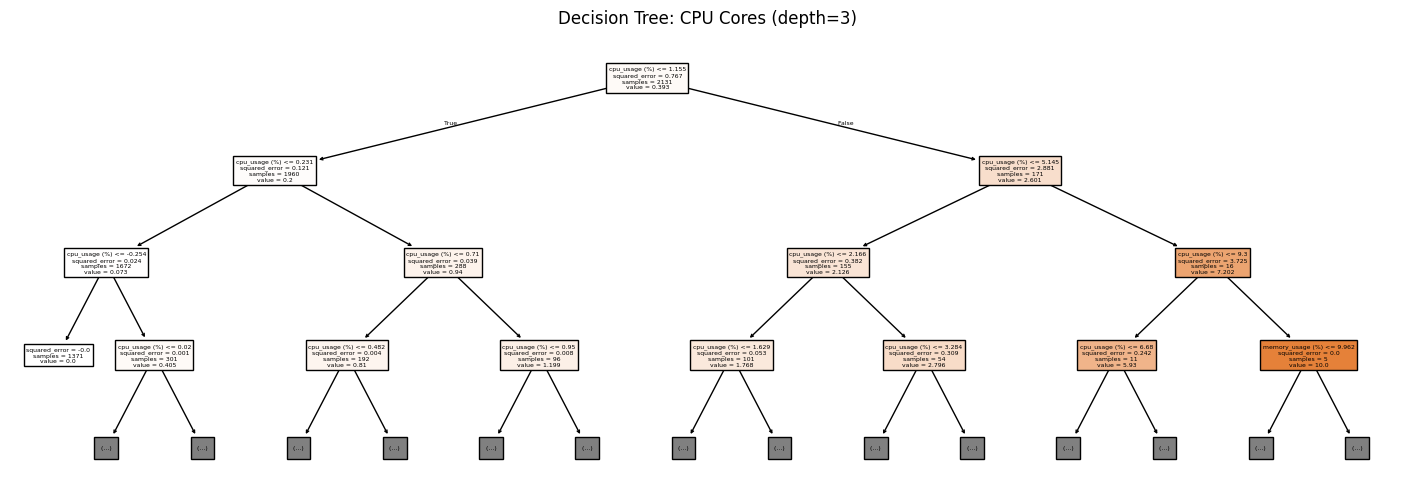

['scaler.joblib']

In [96]:
  import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib

# 1. Load dataset
data = pd.read_csv('autoscaling_dataset.csv')

# 2. Define features and create simulated target columns
features = ['http_req_duration (ms)', 'response_time (ms)', 'vus (users)', 'success_rate (%)',
            'http_reqs (req/sec)', 'cpu_usage (%)', 'memory_usage (%)', 'latency (ms)', 'throughput (req/sec)']

# Simulate targets for now (customize with real logic or real columns if available)
data['target_cpu_cores'] = data['cpu_usage (%)'] / 10
data['target_containers'] = data['vus (users)'] / 5

X = data[features]
y_cpu = data['target_cpu_cores']
y_containers = data['target_containers']

# 3. Split and scale data
X_train, X_test, y_train_cpu, y_test_cpu = train_test_split(X, y_cpu, test_size=0.2, random_state=42)
_, _, y_train_containers, y_test_containers = train_test_split(X, y_containers, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train models
model_cpu = DecisionTreeRegressor(max_depth=5, random_state=42)
model_cpu.fit(X_train_scaled, y_train_cpu)

model_containers = DecisionTreeRegressor(max_depth=5, random_state=42)
model_containers.fit(X_train_scaled, y_train_containers)

# 5. Evaluate CPU model
cpu_preds = model_cpu.predict(X_test_scaled)
mse_cpu = mean_squared_error(y_test_cpu, cpu_preds)
mae_cpu = mean_absolute_error(y_test_cpu, cpu_preds)
r2_cpu = r2_score(y_test_cpu, cpu_preds)

# 6. Evaluate Containers model
cont_preds = model_containers.predict(X_test_scaled)
mse_cont = mean_squared_error(y_test_containers, cont_preds)
mae_cont = mean_absolute_error(y_test_containers, cont_preds)
r2_cont = r2_score(y_test_containers, cont_preds)

# 7. Print metrics
print(f"\n📊 CPU Cores Model Metrics:")
print(f"  - MSE : {mse_cpu:.4f}")
print(f"  - MAE : {mae_cpu:.4f}")
print(f"  - R²  : {r2_cpu:.4f}")

print(f"\n📊 Containers Model Metrics:")
print(f"  - MSE : {mse_cont:.4f}")
print(f"  - MAE : {mae_cont:.4f}")
print(f"  - R²  : {r2_cont:.4f}")

# 8. Plot predictions vs actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_cpu, y=cpu_preds)
plt.plot([y_test_cpu.min(), y_test_cpu.max()], [y_test_cpu.min(), y_test_cpu.max()], 'r--')
plt.title("CPU Cores: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_containers, y=cont_preds)
plt.plot([y_test_containers.min(), y_test_containers.max()], [y_test_containers.min(), y_test_containers.max()], 'r--')
plt.title("Containers: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

# 9. Visualize decision tree (optional)
plt.figure(figsize=(18, 6))
plot_tree(model_cpu, feature_names=features, filled=True, max_depth=3)
plt.title("Decision Tree: CPU Cores (depth=3)")
plt.show()

# 10. Save model and scaler for later use (e.g., API)
joblib.dump(model_cpu, 'cpu_model.joblib')
joblib.dump(model_containers, 'containers_model.joblib')
joblib.dump(scaler, 'scaler.joblib')



📊 CPU Cores Model Metrics:
  - MSE : 0.007901445381393282
  - MAE : 0.07208432539682534
  - R²  : 0.9986018466172062

📊 Containers Model Metrics:
  - MSE : 0.0
  - MAE : 0.0
  - R²  : 1.0

🔮 Predicted CPU Cores: 3.05
🔮 Predicted Containers: 2.00


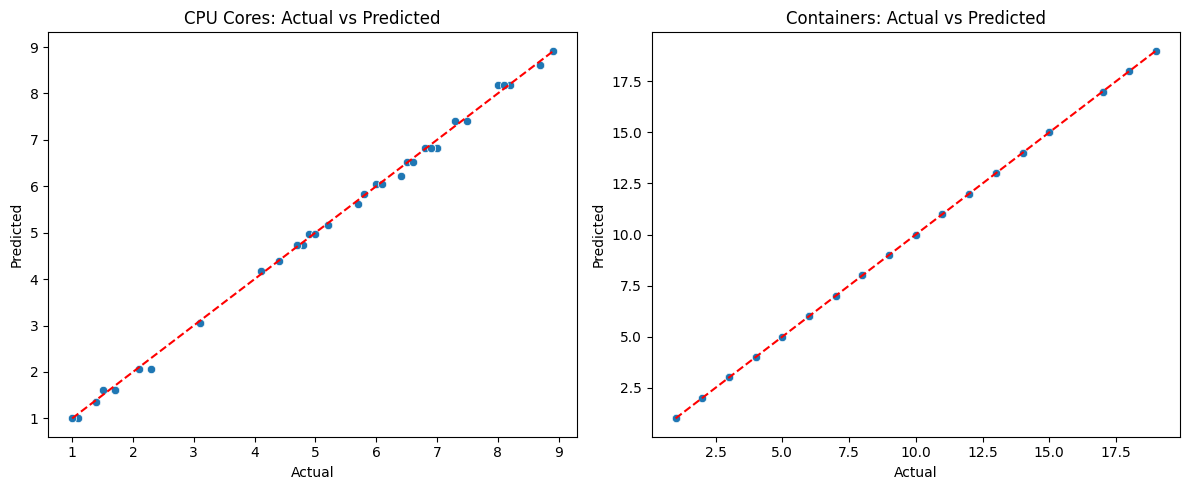

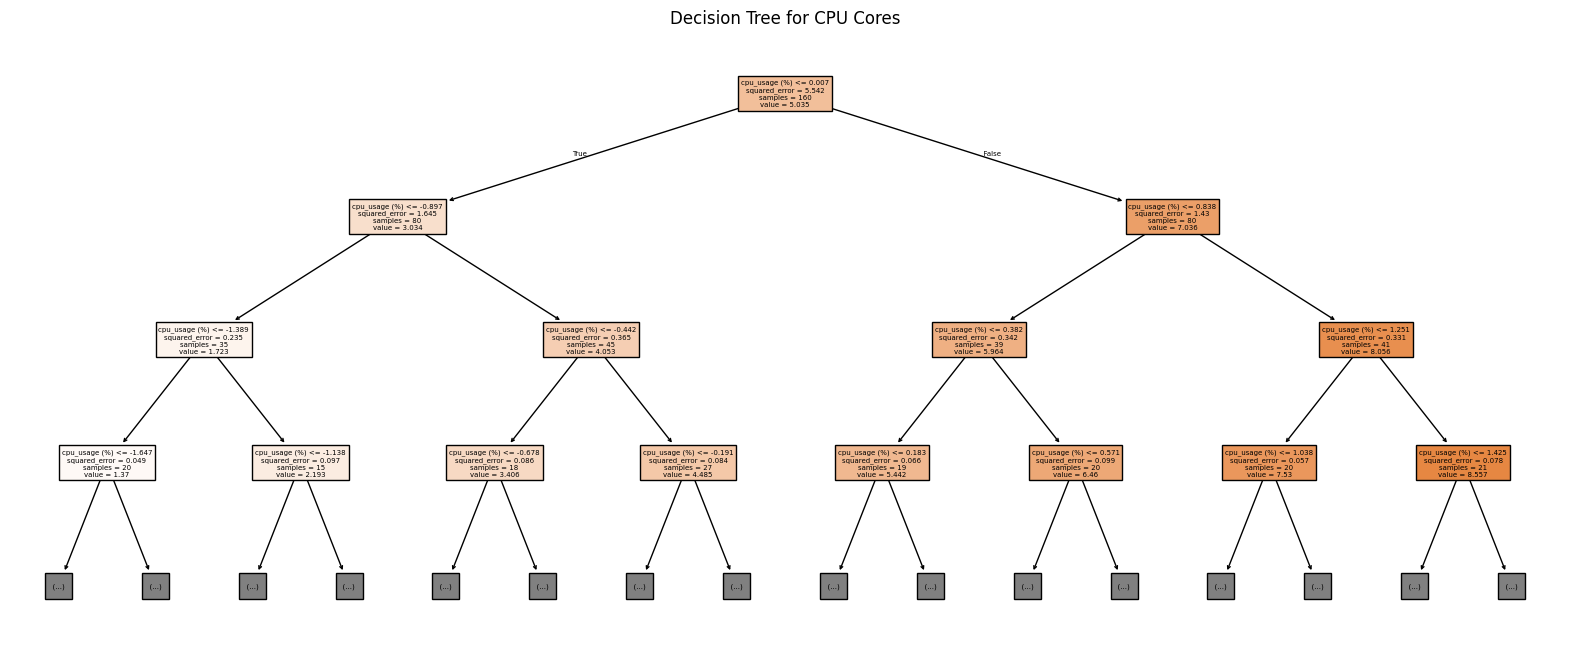

['scaler.joblib']

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib

# Simulated dataset (replace with actual CSV loading)
# Example: data = pd.read_csv("autoscaling_dataset.csv")
np.random.seed(42)
sample_size = 200
data = pd.DataFrame({
    'http_req_duration (ms)': np.random.uniform(50, 500, sample_size),
    'response_time (ms)': np.random.uniform(30, 400, sample_size),
    'vus (users)': np.random.randint(1, 100, sample_size),
    'success_rate (%)': np.random.uniform(95, 100, sample_size),
    'http_reqs (req/sec)': np.random.uniform(50, 1000, sample_size),
    'cpu_usage (%)': np.random.uniform(10, 90, sample_size),
    'memory_usage (%)': np.random.uniform(20, 95, sample_size),
    'latency (ms)': np.random.uniform(10, 2000, sample_size),
    'throughput (req/sec)': np.random.uniform(10, 800, sample_size),
})

# Features and simulated targets
features = ['http_req_duration (ms)', 'response_time (ms)', 'vus (users)', 'success_rate (%)',
            'http_reqs (req/sec)', 'cpu_usage (%)', 'memory_usage (%)', 'latency (ms)', 'throughput (req/sec)']
data['target_cpu_cores'] = (data['cpu_usage (%)'] / 10).round(1)
data['target_containers'] = (data['vus (users)'] / 5).round()

X = data[features]
y_cpu = data['target_cpu_cores']
y_containers = data['target_containers']

# Split and scale
X_train, X_test, y_train_cpu, y_test_cpu = train_test_split(X, y_cpu, test_size=0.2, random_state=42)
_, _, y_train_containers, y_test_containers = train_test_split(X, y_containers, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
model_cpu = DecisionTreeRegressor(max_depth=5, random_state=42)
model_cpu.fit(X_train_scaled, y_train_cpu)

model_containers = DecisionTreeRegressor(max_depth=5, random_state=42)
model_containers.fit(X_train_scaled, y_train_containers)

# Evaluate models
cpu_preds = model_cpu.predict(X_test_scaled)
cont_preds = model_containers.predict(X_test_scaled)

print("\n📊 CPU Cores Model Metrics:")
print("  - MSE :", mean_squared_error(y_test_cpu, cpu_preds))
print("  - MAE :", mean_absolute_error(y_test_cpu, cpu_preds))
print("  - R²  :", r2_score(y_test_cpu, cpu_preds))

print("\n📊 Containers Model Metrics:")
print("  - MSE :", mean_squared_error(y_test_containers, cont_preds))
print("  - MAE :", mean_absolute_error(y_test_containers, cont_preds))
print("  - R²  :", r2_score(y_test_containers, cont_preds))

# Predict on new data
new_data = pd.DataFrame({
    'http_req_duration (ms)': [120],
    'response_time (ms)': [80],
    'vus (users)': [10],
    'success_rate (%)': [99],
    'http_reqs (req/sec)': [200],
    'cpu_usage (%)': [30],
    'memory_usage (%)': [70],
    'latency (ms)': [150],
    'throughput (req/sec)': [120]
})
new_data_scaled = scaler.transform(new_data[features])
cpu_pred_new = model_cpu.predict(new_data_scaled)[0]
cont_pred_new = model_containers.predict(new_data_scaled)[0]

print(f"\n🔮 Predicted CPU Cores: {cpu_pred_new:.2f}")
print(f"🔮 Predicted Containers: {cont_pred_new:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_cpu, y=cpu_preds)
plt.plot([y_test_cpu.min(), y_test_cpu.max()], [y_test_cpu.min(), y_test_cpu.max()], 'r--')
plt.title("CPU Cores: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_containers, y=cont_preds)
plt.plot([y_test_containers.min(), y_test_containers.max()], [y_test_containers.min(), y_test_containers.max()], 'r--')
plt.title("Containers: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

# Plot tree
plt.figure(figsize=(20, 8))
plot_tree(model_cpu, feature_names=features, filled=True, max_depth=3)
plt.title("Decision Tree for CPU Cores")
plt.show()

# Save models
joblib.dump(model_cpu, 'cpu_model.joblib')
joblib.dump(model_containers, 'containers_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
